# More on datasets

* The `torch.utils.data` package have two useful classes for loading and preprocessing
data:
    - `torch.utils.data.Dataset`
    - `torch.utils.data.DataLoader`

Create new datasets by creating a subclass of `torch.utils.data.Dataset`. That is
```
import torch

class ExampleDataset(torch.utils.data.Dataset):
    def __init__(self,params, *args,**kwargs):
        super().__init__(*args,**kwargs)
        # do initalization based on the params,
        # e.g. load images, etc.
        self.data = ...

    def __getitem__(self, idx):
        # return sample indexed with 'idx'
        # must be tensor or dictionary of tensors!
        self.data[idx]

    def __len__(self):
        # return the number of samples
        return self.data.shape[0]
```


## Linear regression dataset
Recall the model 
$$y = ax + b + \epsilon, \quad x\sim \mathcal{N}(0,2) \text{ and } \epsilon \sim \mathcal{N}(0,0.6^2)$$
We can create this data using a dataset object

In [1]:
import torch

class LinearRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, N = 50, a = -3, b = 2, *args,**kwargs):
        # N: number of samples, e.g. 50
        # a: slope
        # b: offset
        super().__init__(*args,**kwargs)
        self.x = 2*torch.randn(N, dtype=torch.float)
        self.noise = 0.6*torch.randn(N, dtype=torch.float)
        self.a = a
        self.b = b

    def __getitem__(self, idx):
        y = self.x[idx] * self.a + self.b + self.noise[idx]
        return self.x[idx], y

    def __len__(self):
        return len(self.x)


Do not transfer the data to the GPU within the dataset class

## Dataset reading images
Create dataset with images contaminated with Gaussian noise.


In [2]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

class ImageNoisyDataset(torch.utils.data.Dataset):
    def __init__(self, root, noise_level, *args,**kwargs):
        super().__init__(*args,**kwargs)
        self.root = root
        self.noise_level = noise_level
        
        imagefiles = [f for f in os.listdir(root) if '.png' in f]
        
        self.N = len(imagefiles)
        
        self.targets = []
        self.inputs = []
        for i in range(self.N):
            fname = os.path.join(root, f'sample_{i:04}.png')
            tar = Image.open(fname)
            tar = np.array(tar, dtype=np.float32)/255 # Scale each pixel to [0,1]
            tar = torch.from_numpy(tar)
            tar = tar.unsqueeze(0) # Change shape from [256,256] to [1, 256, 256]
            
            inp = tar + noise_level*torch.randn_like(tar) # Add noise 
            
            self.targets.append(tar)
            self.inputs.append(inp)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    def __len__(self):
        return self.N

In the example above, we read all images at once. Is this problematic?

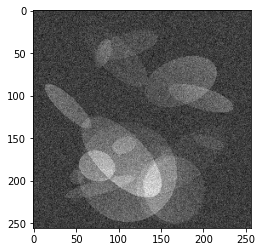

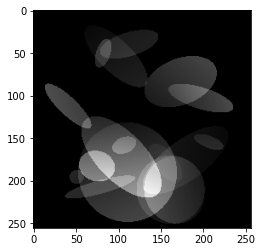

In [3]:
src_data = '/itf-fi-ml/shared/MIEVU4020/v22/data'
noise_level = 0.1

dataset_train = ImageNoisyDataset(os.path.join(src_data, 'train'), noise_level=noise_level)
dataset_val = ImageNoisyDataset(os.path.join(src_data, 'val'), noise_level=noise_level)
dataset_test = ImageNoisyDataset(os.path.join(src_data, 'test'), noise_level=noise_level)


x_noise, x_clean = dataset_train[3]

plt.figure()
plt.imshow(np.squeeze(x_noise.numpy()), cmap='gray');
plt.figure()
plt.imshow(np.squeeze(x_clean.numpy()), cmap='gray');
plt.show()
